# Fractional gates

This page introduces two newly supported gate types on the IBM Quantum fleet of QPUs. These new fractional gate are supported on:
- [Eagle](/guides/processor-types#eagle) QPUs as $R_{ZZ}(\theta)$ and $R_X(\theta)$
- [Heron](/guides/processor-types#heron) QPUs as $R_{ZX}(\theta)$

This page discusses the usecases which enable your quantum workflows to become more efficient using these fractional gates, as well as how to use them on IBM Quantum QPUs.

## Where to use fractional gates

Historically, the basis gates available on QPUs in the fleet of IBM Quantum hardware have been **`ECR`**, **`X`**, **`RZ`**, **`SX`**, and **`ID`** which creates a constraint on circuits with single and two-qubit rotations. For example, an $R_X(\theta)$ gate, when transpiled to a QPU in the IBM Quantum fleet, must decompose into a series of $RZ$ and $\sqrt{X}$ gates -- creating a circuit with a depth of five instead of one.

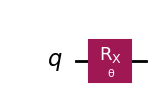

In [32]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization.timeline import draw as draw_timeline, IQXSimple

from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np

qc = QuantumCircuit(1)
param = Parameter('θ')
qc.rx(param, 0)
qc.draw('mpl')

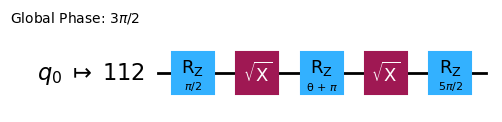

In [28]:
# Decomposition of an RX(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.least_busy()
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl', idle_wires=False)

And the same is true for two-qubit rotations such as an $R_{ZZ}(\theta)$ gate. When transpiled to an IBM Quantum QPU, the decomposition requires two **`ECR`** gates and several single qubit gates, significantly increasing the circuit depth.

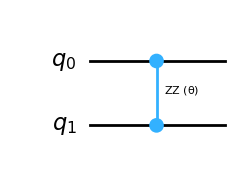

In [29]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np

qc = QuantumCircuit(2)
param = Parameter('θ')
qc.rzz(param, 0, 1)
qc.draw('mpl')

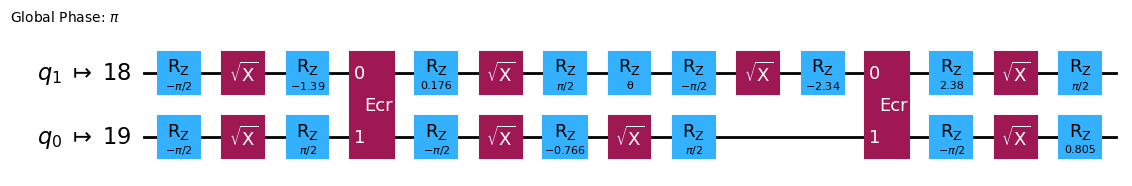

In [30]:
# Decomposition of an RZZ(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.least_busy()
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl', idle_wires=False)

For workflows that require many single qubit $R_X(\theta)$ or two-qubit rotations, especially ones where the rotation angle $\theta$ is small (such as in a variational ansatze or when simulating the time evolution of quantum systems), this constraint causes the circuit depth to grow quite quickly. Thankfully however, the fleet of IBM Quantum QPUs now support *fractional gates* which can significantly reduce the circuit depth for workflows like these.

## How to use fractional gates

Internally, these fractional gates work by dynamically modifying the microwave pulses that are sent to individual qubits based on the angle, $\theta$, that a circuit instruction specifies. This has the advantage of shorter gate durations -- and thus lower dephasing error, especially for small angles -- which reduces the overall circuit duration, in addition to the cost savings of executing fewer gates.

The code example below demonstrates an example workflow of simulating the dynamics of an Ising chain using fractional gates, and compares the circuit duration against a backend which does not use fractional gates.

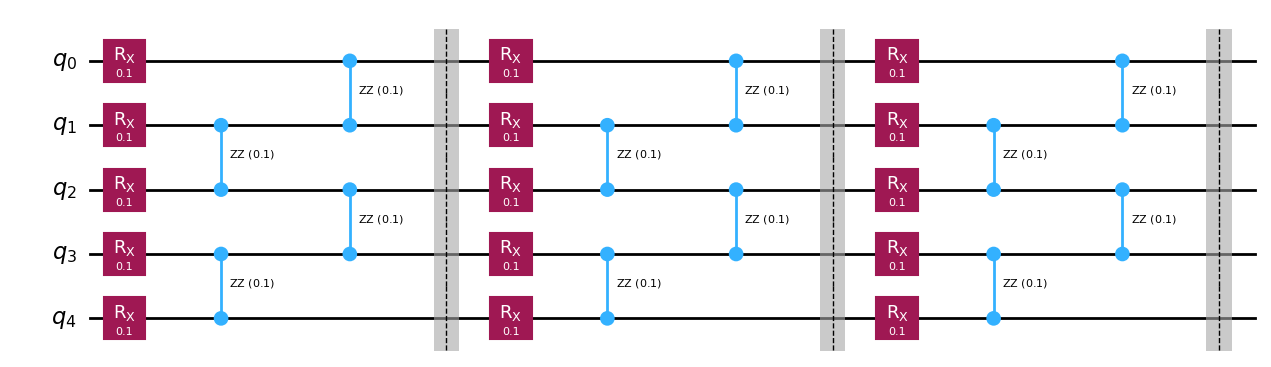

In [37]:
num_qubits = 5
num_time_steps = 3
rx_angle = 0.1
rzz_angle = 0.1

ising_circuit = QuantumCircuit(num_qubits)
for i in range(num_time_steps):
    # rx layer
    for q in range(num_qubits):
        ising_circuit.rx(rx_angle, q)
    for q in range(1, num_qubits-1, 2):
        ising_circuit.rzz(rzz_angle, q, q+1)
    # 2nd rzz layer
    for q in range(0, num_qubits-1, 2):
        ising_circuit.rzz(rzz_angle, q, q+1)
    ising_circuit.barrier()
ising_circuit.draw('mpl')

In [ ]:
# Specify a backend which has fractional gates enabled, allowing a transpiler pass manager to take that into its own context
service = QiskitRuntimeService()
backend_fractional = service.least_busy(use_fractional_gates=True)
backend_conventional = service.least_busy(use_fractional_gates=False)

pm_fractional = generate_preset_pass_manager(optimization_level=3, backend=backend_fractional)
pm_conventional = generate_preset_pass_manager(optimization_level=3, backend=backend_conventional)

ising_circuit_fractional = pm_fractional.run(ising_circuit)
ising_circuit_conventional = pm_conventional.run(ising_circuit)

In [ ]:
# Draw timeline of circuit with conventional gates
draw_timeline(ising_circuit_conventional, idle_wires=False, time_range=(0, 500), style=IQXSimple())

In [ ]:
# Draw timeline of circuit with fractional gates
draw_timeline(ising_circuit_fractional, idle_wires=False, time_range=(0, 500), style=IQXSimple())

### Temporary Code

The code snippets below will be removed before this PR is merged, this is simply to demonstrate how the fractional gates perform in terms of circuit duration while still waiting for their release.

In [38]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.circuit.library.standard_gates import get_standard_gate_name_mapping

backend = FakeTorino()
backend_fractional = FakeTorino()

rzz_gate = get_standard_gate_name_mapping()["rzz"]
rx_gate = get_standard_gate_name_mapping()["rx"]



backend_fractional.target.add_instruction(
    instruction=rzz_gate,
    properties=backend.target["cz"],
)
backend_fractional.target.add_instruction(
    instruction=rx_gate,
    properties=backend.target["sx"],
)

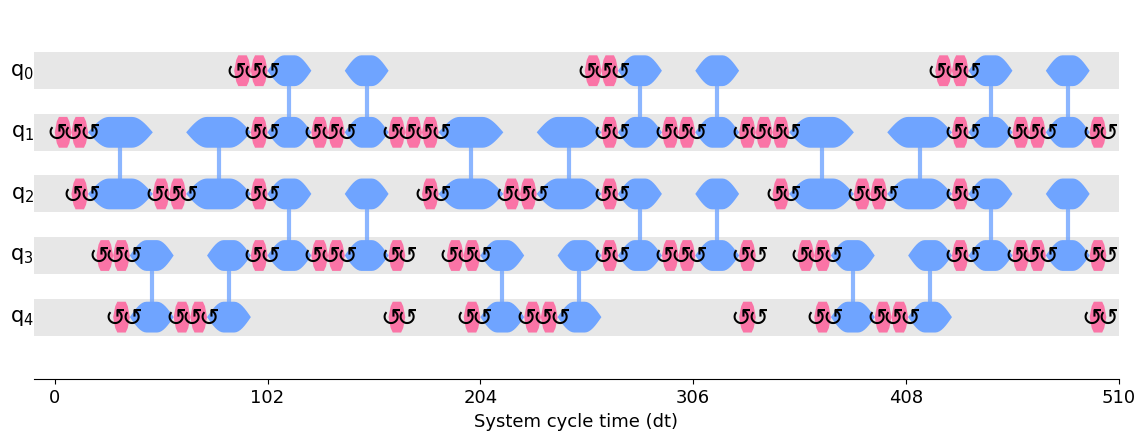

In [41]:
pm = generate_preset_pass_manager(optimization_level=1, target=backend.target, scheduling_method="alap")
isa_conventional = pm.run(ising_circuit)
draw_timeline(isa_conventional, idle_wires=False, time_range=(0, 500), style=IQXSimple())

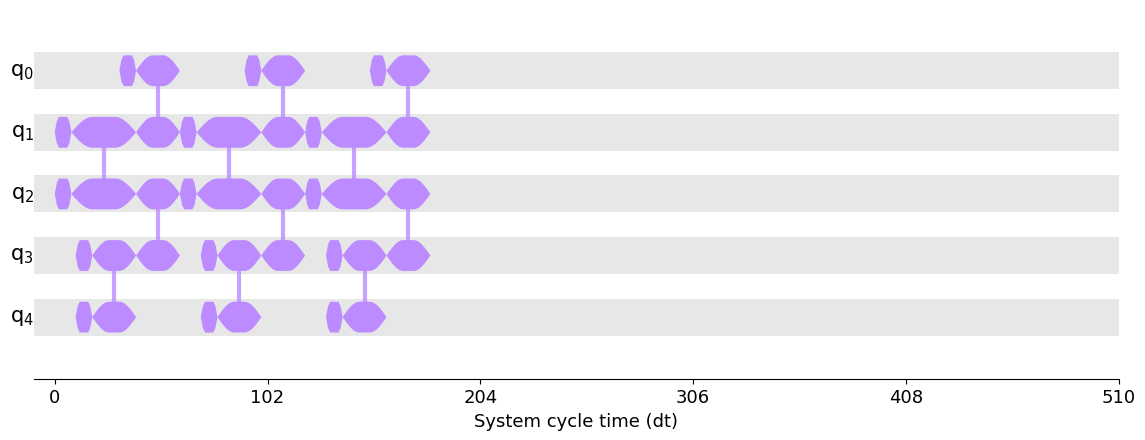

In [42]:
pm_fractional = generate_preset_pass_manager(optimization_level=1, target=backend_fractional.target, scheduling_method="alap")
isa_fractional = pm_fractional.run(ising_circuit)
draw_timeline(isa_fractional, idle_wires=False, time_range=(0, 500), style=IQXSimple())